# 使用 Amazon SageMaker XGBoost 进行预测性维护
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**_

---

---

## 内容

1. [Background](#Background) - 背景
1. [Prepration](#Preparation) - 准备
1. [Data](#Data) - 数据
    1. [Exploration](#Exploration) - 探索
    1. [Transformation](#Transformation) - 变换
1. [Training](#Training) - 训练
1. [Hosting](#Hosting) - 托管
1. [Evaluation](#Evaluation) - 评估模型
1. [Exentsions](#Extensions) - 扩展

---

## Background
《预测性维护》是传统制造业常见AI场景。过去多年，制造业一直在努力提高运营效率，并避免由于组件故障而导致停机。通常使用的方法是：

通常采用的方法是使用“物理传感器（标签）”做数据连接，存储和大屏上进行了大量重复投资，以监视设备状况并获得实时警报。
主要的数据分析方法是单变量阈值和基于物理的建模方法，尽管这些方法在检测特定故障类型和操作条件方面很有效，但它们通常会错过"通过推导每台设备的多元关系"而检测到的重要信息。
借助机器学习，可以提供从设备的历史数据中学习的数据驱动模型。主要挑战在于，Machine Learning(ML)的项目投资和工程师培训，实施这样的机器学习解决方案既耗时又昂贵。
AWS Sagemaker提供了一个简单有效的解决方案，就是使用Sagemaker+XGboost完成检测到异常的设备行为，实现《预测性维护》的场景需求，本文内容覆盖了：

使用了“滑窗”方法进行数据集的重构，并配合XGBoost算法，将多元时间序列数据集转换为监督学习问题（复杂问题转换为简单问题）；
使用Sagemaker Studio各项功能（自动机器学习Autopilot、自动化的调参 Hyperparameter tuning jobs、多模型终端节点multi-model endpoints等）加速XGBoost超参数优化的速度，有效提高模型准确度，并大幅降低日程推理成本；
使用Sagemaker Studio 完成数据预处理与特征工程：
*  1）探索相关性；
*  2）缩小特征值范围；
*  3）将海量数据分为几批进行预处理，以避免服务器内存溢出；
*  4）数据清理，滑动窗口清除无效数据；
*  5）过滤数据，解决正负样本不平衡的问题；
针对实验数据，使用Sagemaker+XGboost训练了6个预测模型，分别覆盖提前5、10、20、30、40、50分钟进行预测，演示预测结果结果。
首先您需要关注的是ML工作流程。即如何使用Amazon SageMaker和XGBoost完成典型ML工作流程中的每个步骤。 在此过程中，您将看到Amazon SageMaker如何使用各种功能来提高ML的效率并同时降低成本。



本笔记本提供了一个示例问题，步骤包括：

* 准备您的 Amazon SageMaker 笔记本
* 从互联网下载数据到 Amazon SageMaker
* 调查和转换数据，以便将其提供给 Amazon SageMaker 算法
* 使用梯度提升算法估计模型
* 评估模型的有效性
* 设置模型以进行持续预测

---

## Preparation

_此笔记本是在 *ml.m5.xlarge* 笔记本实例上创建和测试的。_

让我们从指定开始：

- 要用于训练和模型数据的 S3 存储桶和前缀。这应该与笔记本实例、培训和托管在同一区域内。
- IAM 角色 arn 用于为您的数据提供培训和托管访问权限。有关如何创建这些文件，请参阅文档。请注意，如果笔记本实例、培训和/或托管需要多个角色，请将 boto regexp 替换为适当的完整 IAM 角色 arn 字符串。

In [1]:
conda update pandas

Solving environment: / 
  - defaults/linux-64::six-1.15.0-py37h06a4308_0, defaults/linux-64::tenacity-6.3.1-py37h06a4308_0, defaults/noarch::plotly-5.1.0-pyhd3eb1b0_0
  - defaults/linux-64::plotly-3.6.1-py37_0, defaults/linux-64::retrying-1.3.3-py37_2, defaults/noarch::six-1.16.0-pyhd3eb1b0done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [12]:
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-predictive_maintenance'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Now let's bring in the Python libraries that we'll use throughout the analysis

In [13]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
#from xgboost import XGBRegressor
%matplotlib inline
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
import os
from datetime import datetime
from time import gmtime, strftime, sleep

In [14]:
pd.__version__

'1.2.4'

Make sure pandas version is set to 1.2.4 or later. If it is not the case, restart the kernel before going further

---

## Data



In [ ]:
#!wget https://xxx/test_data.zip

with zipfile.ZipFile('model_data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Now lets read this into a Pandas data frame and take a look.

In [15]:
#为了提高实验速度，第100W行开始取值，读取到最后一行
data_model = pd.read_csv('./model_data/dataset-with-header.csv',skiprows=range(1, 1000000), low_memory=False)

#数据清理： 按照时间排序数组后，然后删除时间的属性
data_model['time']=pd.to_datetime(data_model['time'])
data_model.sort_values('time', inplace=True)
data_model = data_model.drop(['time','shutTime\r'], axis=1)

#数据清理: 转化 code 到 hascode = true/false 
data_model['hascode'] = (np.where(data_model['code'].isnull().values, False, True)).astype(object)
data_model = data_model.drop(['code'], axis=1)
#data_model = data_model.fillna(0) #for testing

#data_model.to_csv('data_temp1.csv', header=True, index=False)  #for testing
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data_model # for testing

,sensor_1_AUXILIQUIDOPENING,sensor_1_COMPCURRENT,sensor_1_COMPEXHAUSTTEMP,sensor_1_COMPLOAD,sensor_1_COMPPOWER,sensor_1_COMPRUNTIME,sensor_1_COMPSPEED,sensor_1_COMPSUCTIONTEMP,sensor_1_COMPVOLTAGE,sensor_1_CONDSIDEEXHAUSTPRESS,sensor_1_DISCHARGESUPERHEAT,sensor_1_ECONPRESS,sensor_1_ECONREFRTEMP,sensor_1_EVAPSIDESUCTIONPRESS,sensor_1_INVERTERTEMP,sensor_1_MAINFLOWVALVEOPENING,sensor_1_MAINLOOPLEVEL,sensor_2_AUXILIQUIDOPENING,sensor_2_COMPCURRENT,sensor_2_COMPEXHAUSTTEMP,sensor_2_COMPLOAD,sensor_2_COMPPOWER,sensor_2_COMPRUNTIME,sensor_2_COMPSPEED,sensor_2_COMPSUCTIONTEMP,sensor_2_COMPVOLTAGE,sensor_2_CONDSIDEEXHAUSTPRESS,sensor_2_DISCHARGESUPERHEAT,sensor_2_ECONPRESS,sensor_2_ECONREFRTEMP,sensor_2_EVAPSIDESUCTIONPRESS,sensor_2_INVERTERTEMP,sensor_2_MAINFLOWVALVEOPENING,sensor_2_MAINLOOPLEVEL,sensor_3_AUXILIQUIDOPENING,sensor_3_COMPCURRENT,sensor_3_COMPEXHAUSTTEMP,sensor_3_COMPLOAD,sensor_3_COMPPOWER,sensor_3_COMPRUNTIME,sensor_3_COMPSPEED,sensor_3_COMPSUCTIONTEMP,sensor_3_COMPVOLTAGE,sensor_3_CONDSIDEEXHAUSTPRESS,sensor_3_DISCHARGESUPERHEAT,sensor_3_ECONPRESS,sensor_3_ECONREFRTEMP,sensor_3_EVAPSIDESUCTIONPRESS,sensor_3_INVERTERTEMP,sensor_3_MAINFLOWVALVEOPENING,sensor_3_MAINLOOPLEVEL,SYSTEM_CONDCAPACITY,SYSTEM_CONDSIDETEMPIN,SYSTEM_CONDSIDETEMPOUT,SYSTEM_EVAPCAPACITY,SYSTEM_EVAPSIDETEMPOUT,SYSTEM_UNITPOWER,hascode
0,100.0,48.0,34.1,NaN,NaN,4415.0,18827.0,4.5,403.0,589.8,273.1,-101.3,-61.5,243.3,0.0,20.0,48.0,0.0,0.0,31.6,0.0,0.0,4415.0,0.0,31.1,407.0,548.8,-248.7,-101.3,-61.4,358.7,0.0,0.0,58.0,NaN,49.0,33.1,NaN,NaN,4416.0,18704.0,4.6,408.0,586.1,-321.8,-101.3,-61.4,244.6,0.0,NaN,56.0,NaN,24.0,25.5,NaN,9.4,NaN,False
1,100.0,50.0,34.4,37.0,NaN,4415.0,18961.0,4.3,402.0,592.4,273.1,-101.3,-61.5,241.8,0.0,NaN,46.0,0.0,0.0,31.6,0.0,0.0,4415.0,0.0,31.1,407.0,546.5,-248.9,-101.3,-61.4,359.0,0.0,0.0,58.0,NaN,49.0,33.1,NaN,NaN,4416.0,18680.0,4.6,405.0,585.6,-321.2,-101.3,-61.4,244.7,0.0,NaN,55.0,NaN,24.0,25.5,NaN,9.4,61.0,False
2,100.0,49.0,34.3,37.0,NaN,4415.0,18946.0,4.5,403.0,592.2,273.1,-101.3,-61.5,243.2,0.0,NaN,46.0,0.0,0.0,31.6,0.0,0.0,4415.0,0.0,31.1,407.0,546.7,-249.0,-101.3,-61.4,358.8,0.0,0.0,58.0,NaN,49.0,33.1,NaN,NaN,4416.0,18688.0,4.6,407.0,585.8,-321.6,-101.3,-61.3,244.9,0.0,NaN,55.0,NaN,24.0,25.5,NaN,9.4,NaN,False
3,100.0,50.0,34.3,NaN,NaN,4415.0,18941.0,4.5,404.0,591.8,273.1,-101.3,-61.5,243.5,0.0,26.0,45.0,0.0,0.0,31.6,0.0,0.0,4415.0,0.0,31.1,407.0,549.2,-248.5,-101.3,-61.4,359.4,0.0,0.0,58.0,NaN,49.0,33.1,NaN,NaN,4416.0,18682.0,4.6,408.0,585.6,-321.2,-101.3,-61.4,245.1,0.0,NaN,54.0,NaN,24.0,25.6,NaN,9.4,NaN,False
4,100.0,49.0,34.1,NaN,NaN,4415.0,18856.0,4.6,403.0,590.9,273.1,-101.3,-61.5,245.8,0.0,NaN,51.0,0.0,0.0,31.6,0.0,0.0,4415.0,0.0,31.1,408.0,550.1,-249.9,-101.3,-61.4,359.6,0.0,0.0,58.0,NaN,49.0,33.1,NaN,NaN,4416.0,18679.0,4.6,407.0,586.4,-321.4,-101.3,-61.3,246.4,0.0,NaN,55.0,NaN,24.0,25.6,NaN,9.4,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875655,100.0,37.0,25.9,42.3,21.3,8093.0,16410.0,6.0,376.0,442.7,273.1,-101.3,-61.5,259.8,0.0,32.8,52.0,100.0,38.0,26.9,NaN,22.0,8189.0,16203.0,7.8,379.0,462.0,-294.2,-101.3,-61.5,283.3,0.0,NaN,50.0,100.0,37.0,25.1,43.1,21.2,7518.0,16181.0,6.1,381.0,444.6,-287.3,-101.3,-61.2,260.8,0.0,32.1,56.0,1192.08,16.3,18.8,1239.76,10.0,64.5,False
875656,100.0,37.0,25.9,42.4,21.4,8093.0,16426.0,6.0,377.0,443.0,273.1,-101.3,-61.5,259.7,0.0,32.6,49.0,100.0,38.0,26.9,NaN,NaN,8189.0,16210.0,7.8,381.0,462.2,-294.1,-101.3,-61.5,282.9,0.0,NaN,50.0,100.0,36.0,25.1,42.5,21.0,7518.0,16185.0,6.1,382.0,444.7,-288.0,-101.3,-61.2,261.4,0.0,32.1,55.0,1192.08,16.3,18.8,1239.76,10.0,64.5,False
875657,100.0,38.0,25.9,42.5,21.4,8093.0,16436.0,6.0,378.0,443.6,273.1,-101.3,-61.5,259.2,0.0,32.7,47.0,100.0,38.0,26.9,NaN,NaN,8189.0,16212.0,7.8,381.0,462.8,-293.8,-101.3,-61.6,283.0,0.0,NaN,50.0,100.0,36.0,25.3,42.1

### 让我们来谈谈数据。在高层次上，我们可以看到：
按照现代标准，这是一个相对较大的数据集，有 130W 条记录。 每条记录使用超过58个属性来描述设备信息。 这些属性如下：

1. time:设备timestamp（时间打点） 
1. sensor_1_XXX：传感器信息
1. sensor_2_XXX：传感器信息
1. sensor_3_XXX：传感器信息
1. ....
1. shuttime: 设备 code 发生的时间（警告故障发生时间）
1. code：设备故障代码（分类，代表不同的报警类型）

最后一个属性 code 称为目标属性，即我们希望 ML 模型预测的属性。





### Exploration

让我们开始探索数据。 首先，让我们了解特征是如何分布的。

* 开始探索数据以及属性之间的关系并使其实现可视化，用直方图来查看各个属性的值的分布情况，并计算出值属性的汇总统计数据，如均值、最小值、最大值、标准差等。 
* 对于类别变量，我们需要查看频率表。更为直观的方法是为每个数值特征构建直方图；

,sensor_1_AUXILIQUIDOPENING,sensor_1_COMPCURRENT,sensor_1_COMPEXHAUSTTEMP,sensor_1_COMPLOAD,sensor_1_COMPPOWER,sensor_1_COMPRUNTIME,sensor_1_COMPSPEED,sensor_1_COMPSUCTIONTEMP,sensor_1_COMPVOLTAGE,sensor_1_CONDSIDEEXHAUSTPRESS,sensor_1_DISCHARGESUPERHEAT,sensor_1_ECONPRESS,sensor_1_ECONREFRTEMP,sensor_1_EVAPSIDESUCTIONPRESS,sensor_1_INVERTERTEMP,sensor_1_MAINFLOWVALVEOPENING,sensor_1_MAINLOOPLEVEL,sensor_2_AUXILIQUIDOPENING,sensor_2_COMPCURRENT,sensor_2_COMPEXHAUSTTEMP,sensor_2_COMPLOAD,sensor_2_COMPPOWER,sensor_2_COMPRUNTIME,sensor_2_COMPSPEED,sensor_2_COMPSUCTIONTEMP,sensor_2_COMPVOLTAGE,sensor_2_CONDSIDEEXHAUSTPRESS,sensor_2_DISCHARGESUPERHEAT,sensor_2_ECONPRESS,sensor_2_ECONREFRTEMP,sensor_2_EVAPSIDESUCTIONPRESS,sensor_2_INVERTERTEMP,sensor_2_MAINFLOWVALVEOPENING,sensor_2_MAINLOOPLEVEL,sensor_3_AUXILIQUIDOPENING,sensor_3_COMPCURRENT,sensor_3_COMPEXHAUSTTEMP,sensor_3_COMPLOAD,sensor_3_COMPPOWER,sensor_3_COMPRUNTIME,sensor_3_COMPSPEED,sensor_3_COMPSUCTIONTEMP,sensor_3_COMPVOLTAGE,sensor_3_CONDSIDEEXHAUSTPRESS,sensor_3_DISCHARGESUPERHEAT,sensor_3_ECONPRESS,sensor_3_ECONREFRTEMP,sensor_3_EVAPSIDESUCTIONPRESS,sensor_3_INVERTERTEMP,sensor_3_MAINFLOWVALVEOPENING,sensor_3_MAINLOOPLEVEL,SYSTEM_CONDCAPACITY,SYSTEM_CONDSIDETEMPIN,SYSTEM_CONDSIDETEMPOUT,SYSTEM_EVAPCAPACITY,SYSTEM_EVAPSIDETEMPOUT,SYSTEM_UNITPOWER
count,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.00000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000,876102.000000
mean,46.647068,29.333749,29.864098,20.057250,17.104330,5966.419572,9255.189992,15.592098,396.006787,567.336763,273.038637,-101.291224,-61.507032,307.425597,0.000298,14.468270,46.222869,43.828947,31.205691,30.626304,2.274471,1.872894,5908.043351,9508.11054,16.455703,399.276081,570.817768,-291.886271,-101.293359,-61.477571,319.695590,0.000038,1.748595,49.925107,35.441097,24.628306,28.969531,16.463130,13.615455,5590.346718,7587.024454,17.619172,400.865211,564.802642,-281.470450,-101.297687,-61.402532,313.156284,0.000180,10.936002,52.504884,684.844525,24.227948,25.716808,586.386722,10.643083,49.897302
std,49.477173,34.305435,8.276531,22.579533,20.615666,1067.146945,9721.274096,11.401005,13.191703,83.091621,4.102425,1.256802,2.814260,53.639791,0.106393,16.490511,12.719086,49.570774,35.633785,8.233102,10.239133,8.904620,1067.405511,9658.40966,10.910877,12.990227,89.336875,38.098980,0.922583,2.785289,49.821771,0.035256,7.104585,15.554558,47.432342,33.776964,8.345037,22.716201,19.884630,780.283026,9465.121954,11.727967,16.487348,78.813750,37.071979,0.483997,3.376424,50.145735,0.084961,14.770799,14.728387,601.123062,3.686279,3.949682,457.811501,1.324755,42.579309
min,0.000000,0.000000,-273.100000,0.000000,0.000000,0.000000,0.000000,-273.100000,0.000000,0.000000,-327.100000,-101.300000,-273.100000,-101.300000,0.000000,0.000000,0.000000,0.000000,0.000000,-273.100000,0.000000,0.000000,0.000000,0.00000,-273.100000,0.000000,0.000000,-399.200000,-101.300000,-273.100000,-101.300000,0.000000,0.000000,0.000000,0.000000,0.000000,-273.100000,0.000000,0.000000,0.000000,0.000000,-273.100000,0.000000,0.000000,-420.900000,-101.300000,-273.100000,-101.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,26.100000,0.000000,0.000000,5068.000000,0.000000,5.800000,387.000000,492.700000,273.100000,-101.300000,-61

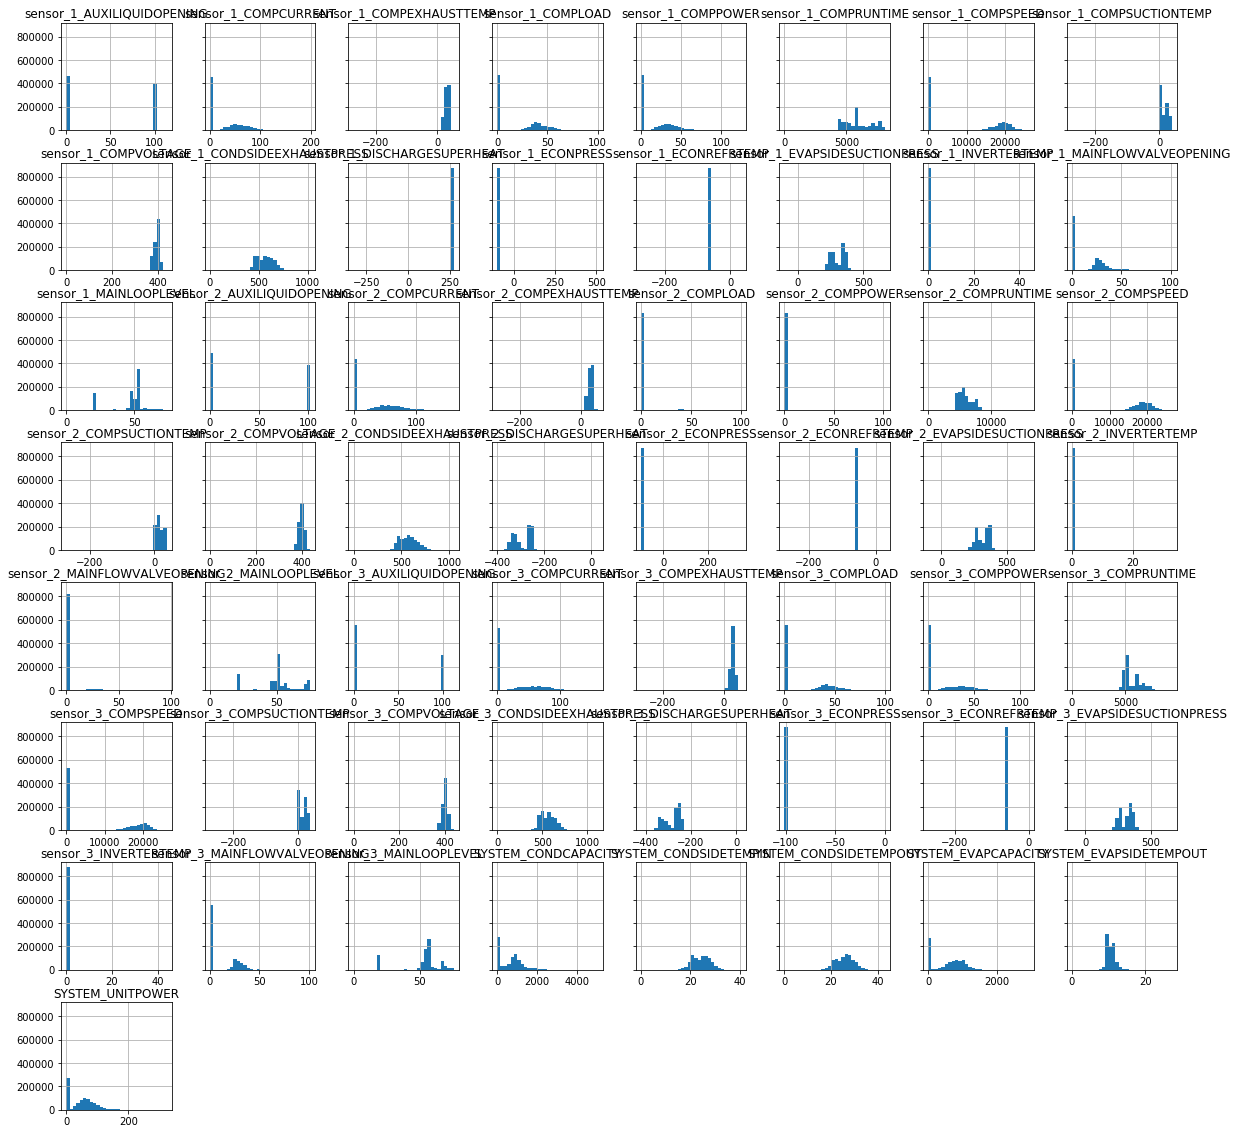

In [16]:
#数据探索数据集: data_exploration
data_exploration = data_model.fillna(0) # 空置赋值为0
#为了提高实验速度，读取10W行
#data_exploration = data_model.head(100000).fillna(0) # 空置赋值为0  # for testing

# 每个分类特征的频率表
for column in data_exploration.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data_exploration[column], columns='% observations', normalize='columns'))

# 显示汇总统计数据
display(data_exploration.describe())

# 每个数字特征的直方图
%matplotlib inline
hist = data_exploration.hist(bins=30, sharey=True, figsize=(20, 20))

#### 相关性探索：对设备不同属性之间的成对关系探索，了解它们之间的关系

【请注意】在海量数据下与原始列的情况下，使用pandas函数 corr() 和 scatter_matrix()反复画图验证，锁定了以下属性之间具体相关性。方法如下，但是中间反复尝试的的裁剪过程被省略。
函数参考：https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.scatter_matrix.html

#### (1)设备主信息 - 相关性探索后，缩小的特征值范围，字段有：
* 'SYSTEM_CONDCAPACITY',
* 'SYSTEM_CONDSIDETEMPIN',
* 'SYSTEM_CONDSIDETEMPOUT',
* 'SYSTEM_EVAPCAPACITY',
* 'SYSTEM_EVAPSIDETEMPOUT',
* 'SYSTEM_UNITPOWER'


,SYSTEM_CONDCAPACITY,SYSTEM_CONDSIDETEMPIN,SYSTEM_CONDSIDETEMPOUT,SYSTEM_EVAPCAPACITY,SYSTEM_EVAPSIDETEMPOUT,SYSTEM_UNITPOWER,hascode
SYSTEM_CONDCAPACITY,1.000000,0.015724,0.318641,0.843260,-0.296681,0.752910,0.030607
SYSTEM_CONDSIDETEMPIN,0.015724,1.000000,0.949409,0.186298,-0.203519,0.413603,0.115578
SYSTEM_CONDSIDETEMPOUT,0.318641,0.949409,1.000000,0.425926,-0.293863,0.613187,0.117841
SYSTEM_EVAPCAPACITY,0.843260,0.186298,0.425926,1.000000,-0.445088,0.905568,0.075570
SYSTEM_EVAPSIDETEMPOUT,-0.296681,-0.203519,-0.293863,-0.445088,1.000000,-0.441749,-0.130251
SYSTEM_UNITPOWER,0.752910,0.413603,0.613187,0.905568,-0.441749,1.000000,0.090391
hascode,0.030607,0.115578,0.117841,0.075570,-0.130251,0.090391,1.000000


SYSTEM_CONDCAPACITY


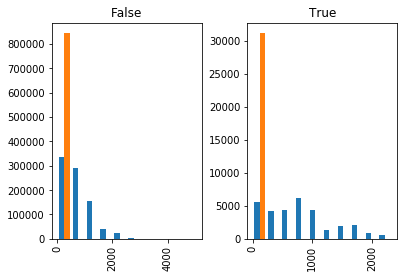

SYSTEM_CONDSIDETEMPIN


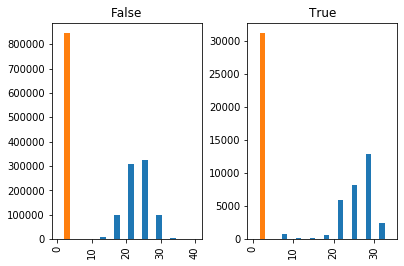

SYSTEM_CONDSIDETEMPOUT


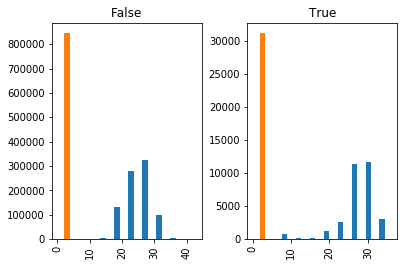

SYSTEM_EVAPCAPACITY


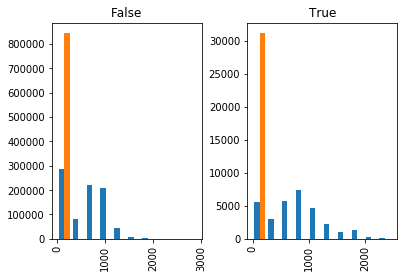

SYSTEM_EVAPSIDETEMPOUT


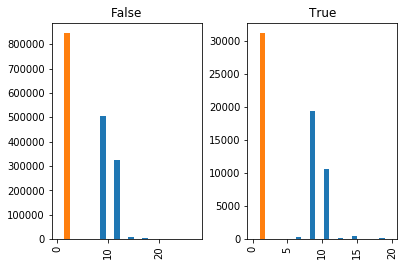

SYSTEM_UNITPOWER


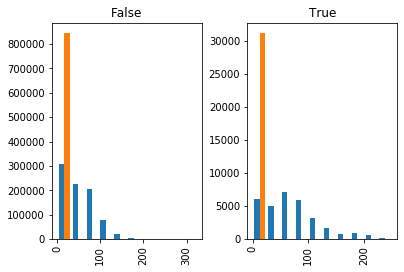

hascode


In [17]:
#为了提高实验速度，读取10W行
#data_exploration = data_model.head(100000) # for testing

#设备主信息
data_exploration = data_exploration[[
'SYSTEM_CONDCAPACITY',
'SYSTEM_CONDSIDETEMPIN',
'SYSTEM_CONDSIDETEMPOUT',
'SYSTEM_EVAPCAPACITY',
'SYSTEM_EVAPSIDETEMPOUT',
'SYSTEM_UNITPOWER',
'hascode'
]]

# 相关性探索：看看每个特征与目标变量 `hasCode` 之间的关系。
#pandas中的data.corr()函数方法说明及使用 数据相关性分析中，经常用到data.corr()函数，
#data.corr()表示了data中的两个变量之间的相关性，取值范围为[-1,1],取值接近-1，表示反相关，类似反比例函数，取值接近1，表正相关
display(data_exploration.corr())


# 相关性探索：看看每个特征与目标变量 `hasCode` 之间的关系。
for column in data_exploration.select_dtypes(exclude=['object']).columns:
    print(column)
    if column != 'hascode':
        hist = data_exploration[[column, 'hascode']].hist(by='hascode', bins=10)
        plt.show()


#### 总结：完成了本章节的内容，包括：
   * 1）探索相关性过程中，发现：特征彼此之间的关系千差万别。 一些具有高度负相关，另一些具有高度正相关。
   * 2）缩小特征值范围：在许多情况下，特征之间的关系是非线性和离散的。
   * 3）数据集从原始数据集的282列，缩减为58个列


### Transformation

数据的预处理和数据转换变形，几乎是每个机器学习项目的一部分。如果操作不当，它可以说是最大的风险，并且是该过程中更主观的方面之一。

#### 本章节内容Contents

1. [数据预处理与特征工程]
2. [滑动窗口的代码实现]
3. [数据预处理]
4. [样本不均衡处理]
5. [数据标注与特征工程]

---

In [21]:
## [滑窗值：合并多少条记录在一起] 【真实结果为 n+1 】
n_slidingwindow = 10  #n_slidingwindow = 100
## [提前n个周期预警, 分钟 = n/2 分钟预警（30s一个间隔）] ，应该小于滑窗值
n_earlywarningcycle = 6
## 共计58个属性column
n_totalcolumns = 58 

#周期预警的开始位
n_combinrows = n_earlywarningcycle
print('滑窗值 == ' + str(n_slidingwindow) +  ', 提前n个周期预警 == ' + str(n_earlywarningcycle) )

# 定义函数 #

# 时间序列数据集转换为监督学习问题，将《多列时间序列数据》转换为《监督学习问题》Transform the timeseries data into supervised learning
# 参数: data=原始数据集；n_in=滑窗值（合并多少条时序记录合并在一起）；dropnan=是否保留华创后部分为空的记录；
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
       n_vars = 1 if type(data) is list else data.shape[1]
       df = DataFrame(data)
       cols = list()
        
       # input sequence (t-n, ... t-1)
       for i in range(n_in, 0, -1):
              cols.append(df.shift(i))
                
       # forecast sequence (t, t+1, ... t+n)
       for i in range(0, n_out):
              cols.append(df.shift(-i))
                
       # put it all together
       agg = concat(cols, axis=1)
        
       # drop rows with NaN values
       if dropnan:
              agg.dropna(inplace=True)
       return agg.values


# 对数据集进行分段滑窗，从而避免内存溢出；
# 参数：data=原始数据集；n_in=滑窗值（合并多少条时序记录合并在一起）；splite_md=行分段的数量，分的越小内存占用越小
def splite_series_to_supervised(data, n_in=1, splite_md=500000):
    splited_series_to_supervised = pd.DataFrame()  #定义一个临时的dataframe，用于解决内存溢出的问题
    # start, stop, step 三个参数可以为负数
    for i in range(0,len(data),splite_md):
        print('/ total= '+str(len(data))+', now splited_working_number= ' + str(i)), # for testing    
        splited_series_to_supervised = splited_series_to_supervised.append(DataFrame(
            series_to_supervised(data.iloc[ i : i+splite_md ], n_in=n_in, dropnan=False)))
        #print(data.iloc[ i : i+splite_md ].info()) # for testing
    
    return splited_series_to_supervised


#滑窗后处理：滑窗后的数据清理，将不是最后错误之前发生的滑窗全部删除
# 用 n_slidingwindow（滑窗数量） 做一个循环：不考虑（查询）最后一位的hascode，前面所有hascode=1 (每间隔58个列的第一个是hascode=true/false)的行全部删除；
# 即：只保留全部hascode=0的行(没有错误发生的行) 与 最后一位hascode=1的行(第一个错误发生的行)
def clear_supervised(data, n_slidingwindow, n_totalcolumns):
    count = 0
    while count < n_slidingwindow :
        n_colnum = count * n_totalcolumns
        data.drop(index=data[data[n_colnum].isin([True])].index, inplace=True)
        print('/ total = '+str(n_slidingwindow) +', now working on = ' + str(count)), # for testing
        #print('column num= '+ str(n_colnum)) # for testing
        count = count + 1
    
    return data

#-----------------------#-----------------------#-----------------------

# 滑窗后处理：正确滑窗，应该是 “有错和无错，各自一条”； 同时适用于pd.sample随机
#即：挑出报错时的最后一条数据 + 删除上面N条未报错数据（上一条正常数据为行数为 except - n）
def pickup_supervised_4train(data, n_slidingwindow, n_totalcolumns, splite_md=500000):
    splited_series_to_supervised = pd.DataFrame()  #定义一个临时的dataframe，用于解决内存溢出的问题
    
    for i in range(0,len(data),splite_md):
        print('\nworking_number ==' + str(i)), # for testing    

        splited_data= data.iloc[ i : i+splite_md ]
        splited_data.reset_index(drop=True,inplace=True)
        print('/ splited_data ==== '+str(splited_data.shape[0])),

        n_checkpoint = n_totalcolumns * n_slidingwindow # 检查点位数 
        index_hascode_truerows = splited_data[splited_data[n_checkpoint].isin([True])].index #检查点列 为真的Index号，用于下一步挑出来
        print('/ index_hascode_truerows ====== '+str(index_hascode_truerows)),

        target_data = pd.DataFrame(data=splited_data,index=index_hascode_truerows) # 把检查点列 为真 挑出来
        target_data = target_data.append(pd.DataFrame(data=splited_data,index=index_hascode_truerows-n_slidingwindow)) # 【-滑窗数量可以取到完全不同的validi值，适用于sample随机】把检查点列 为真的上n行，挑出来 (N等于滑窗个数)
        target_data[n_checkpoint].fillna(0, inplace=True) #上一行的 检查点列 有可能是空的，空值清洗为0
        print('/ target_data ======== '+ str(target_data.shape[0])),

        splited_series_to_supervised = splited_series_to_supervised.append(target_data)

    print('\n========================================')
    print('splited_series_to_supervised  ============================== '+ str(splited_series_to_supervised.shape[0])) # for testing1
    splited_series_to_supervised.drop_duplicates(inplace=True) #清除重复的行（造成1增加）
    return splited_series_to_supervised

# 滑窗后处理：正确滑窗，应该是 “有错和无错，各自一条”； 同时适用于pd.sample随机
# 即：挑出报错时的最后一条数据 + 删除上面N条未报错数据（上一条正常数据为行数为 except - n）
# 样本不均衡处理：以状态位=1的row为准，向上画出一个状态位=0的矩阵，从而仅保留部分状态位=0的滑窗集合（非故障数据集的筛选）
def pickup_supervised_4train_imbalance(data, n_slidingwindow, n_totalcolumns, splite_md=500000):
    splited_series_to_supervised = pd.DataFrame()  #定义一个临时的dataframe，用于解决内存溢出的问题
    
    for i in range(0,len(data),splite_md):
        print('\nworking_number ==' + str(i)), # for testing    

        splited_data= data.iloc[ i : i+splite_md ]
        splited_data.reset_index(drop=True,inplace=True)
        print('/ splited_data ==== '+str(splited_data.shape[0])),

        n_checkpoint = n_totalcolumns * n_slidingwindow # 检查点位数 
        index_hascode_truerows = splited_data[splited_data[n_checkpoint].isin([True])].index #检查点列 为真的Index号，用于下一步挑出来
        print('/ index_hascode_truerows ====== '+str(index_hascode_truerows)),

        target_data = pd.DataFrame(data=splited_data,index=index_hascode_truerows) # 把检查点列 为真 挑出来
        
          #--- 以状态位=1的row为准，向上画出一个状态位=0的矩阵 ---# 
        for i in range(1,n_slidingwindow+1): 
            target_data = target_data.append(pd.DataFrame(data=splited_data,index=index_hascode_truerows-i)) # 把检查点列 为真的上n滑窗行，挑出来 (N等于滑窗个数)，不适用于sample随机
            #print(' DivRows=' + str(i)), #for testing
            
        target_data[n_checkpoint].fillna(0, inplace=True) #上一行的 检查点列 有可能是空的，空值清洗为0
        print('/ target_data ======== '+ str(target_data.shape[0])),

        splited_series_to_supervised = splited_series_to_supervised.append(target_data)

    print('\n========================================')
    print('splited_series_to_supervised  ============================== '+ str(splited_series_to_supervised.shape[0])) # for testing1
    splited_series_to_supervised.drop_duplicates(inplace=True) #清除重复的行（造成1增加）    
    return splited_series_to_supervised

#-----------------------#-----------------------#-----------------------


# 滑窗后处理：准备xgboost的Lable数据集，处理：
# 1）将最后的hasissuce code lable放入第一列； 
# 2）删除合并后最后一行row的信息（共计58个属性column）
def ready4inference_supervised(data, n_slidingwindow, n_totalcolumns, n_combinrows):
    #两个工作：1）把最后的一位 hascode=true/false 挪到了第一位作为lable； 2）删除最后的58个属性列；    
    n_lasthascodepoint = n_slidingwindow*n_totalcolumns
    print('n_lasthascodepoint=' + str(n_lasthascodepoint))
    
    n_drop_end = (n_slidingwindow + 1) * n_totalcolumns # 需要增加58个column才是end；
    print('n_drop_end=' + str(n_drop_end))
    
    n_drop_start = (n_slidingwindow - n_combinrows) * n_totalcolumns
    print('n_drop_start=' + str(n_drop_start))
    
    data = pd.concat([data[n_lasthascodepoint], 
                            data.drop(data.iloc[:, n_drop_start:n_drop_end], axis=1)], axis=1) 
    print('\nFINALL data  ============================== '+ str(data.shape[0])) # for testing

    return data

# inference预测处理：传入modeldata数据和 sagemaker inference handle，获得预测结果
def sagemaker_predict(data, xgb_predictor, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join(
            [predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')


滑窗值 == 10, 提前n个周期预警 == 6


#### 滑动窗口原理解析
* 滑动窗口方法，是使用先前的时间步长预测下一个时间步长，在统计资料中它也称为滞后法。使用滑动窗口方法，可以将《多元时间序列数据集》转换为《监督学习问题》。

#### 样本不均衡处理
* 由于预测性维护的业务特性，导致了故障样本占整体数据样本的比例极低。实验数据中，故障样本比例大约是全部数据集合的万分之五。这是符合业务真实情况的，也是可以理解的。
* 因为实际业务场景中，如果一个设备总是处于故障中，用户早就退货处理了，没有机会能让你收集到高比例的故障数据。不管如何，这么悬殊的样本会大幅度降低预测模型的准确度。
* 本次实验数据，因为在前期调研中深入的理解了用户业务情况，所以通过了更简单的思路解决了样本不均衡问题。即数据集以时间序列顺向排序，以故障发生记录点为原点 - 向过去的时间序列投影进行取值，从而覆盖故障发生前的各种阈值的变化情况。

In [19]:
# 将 “Ishascode =true/false”的列置换到第一列，作为分类Lable
data_trans = pd.get_dummies(data_model)
data_trans = pd.concat([data_trans['hascode_True'], data_trans.drop(
    ['hascode_False', 'hascode_True'], axis=1)], axis=1)
data_trans

In [22]:
#数据滑窗 1 ： 分段滑窗，避免内存溢出 - transform the timeseries data into supervised learning
data_trans = splite_series_to_supervised(data_trans, n_slidingwindow, 50000)

In [23]:
# 滑窗后数据处理 2，清理不符合要求的滑入数据；
data_trans = clear_supervised(data_trans, n_slidingwindow, n_totalcolumns)
#data_trans.to_csv('clearsupervised_data.csv', header=False, index=False) # has NO header for xgboost bin:log

# 校验查询用
n_checkpoint = n_totalcolumns * n_slidingwindow # 检查点位数  
print('\nAfter clear_supervised data_trans issue rows on point = ' + str(n_checkpoint))
#data_trans[data_trans[n_checkpoint].isin([True])].info()  ## 校验查询用 #for testing
print('\nAfter clear_supervised data_trans total  ============================== ')
data_trans.info()  ## 校验查询用 #for testing
#data_trans # for testing

/ total = 10, now working on = 0
/ total = 10, now working on = 1
/ total = 10, now working on = 2
/ total = 10, now working on = 3
/ total = 10, now working on = 4
/ total = 10, now working on = 5
/ total = 10, now working on = 6
/ total = 10, now working on = 7
/ total = 10, now working on = 8
/ total = 10, now working on = 9

After clear_supervised data_trans issue rows on point = 580

After clear_supervised data_trans total  ============================== 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 410615 entries, 0 to 25084
Columns: 638 entries, 0 to 637
dtypes: float64(638)
memory usage: 2.0 GB


In [24]:
#滑窗后数据处理 3： 分段挑选有效数据，避免内存溢出
data_trans = pickup_supervised_4train_imbalance(data_trans,n_slidingwindow, n_totalcolumns, splite_md=50000)
#data_trans.to_csv('pickupsmallsupervisedfortrain_data.csv', header=False, index=False) # has NO header for xgboost bin:log

print('\nFINALL clear_supervised data_trans issue rows on point = ' + str(n_checkpoint))
data_trans[data_trans[n_checkpoint].isin([True])].info()  ## 校验查询用 #for testing
print('\nFINALL data_trans  ============================== '+ str(data_trans.shape[0])) # for testing
#data_trans.info()  ## 校验查询用 #for testing
#data_trans #for testing


working_number ==0
/ splited_data ==== 50000
/ index_hascode_truerows ====== Int64Index([  312,   736,   774,   827,   922,   923,   928,  1741,  1916,
             6235,  7726,  7736,  9963, 11029, 11038, 11127, 11136, 11149,
            13440, 13451, 13452, 46353, 46392, 46398, 46410, 46852, 47382,
            47546, 47566, 47703, 47744, 47919, 47940, 47960, 48015, 49342,
            49384, 49639, 49647, 49737],
           dtype='int64')
/ target_data ======== 440

working_number ==50000
/ splited_data ==== 50000
/ index_hascode_truerows ====== Int64Index([   75,  1155,  1430,  2535,  2568,  8301,  9658,  9703,  9750,
             9842,
            ...
            42404, 42411, 42481, 43133, 43716, 43754, 44935, 44981, 45194,
            48316],
           dtype='int64', length=159)
/ target_data ======== 1749

working_number ==100000
/ splited_data ==== 50000
/ index_hascode_truerows ====== Int64Index([  213,  5565,  5570,  7817,  7871,  8089,  8103,  8105,  8170,
             8218

In [25]:
#滑窗后数据处理 4：准备xgboost training lable的标志位
data_trans = ready4inference_supervised(data_trans,n_slidingwindow, n_totalcolumns,n_combinrows)
#data_trans.to_csv('ready4inference_data.csv', header=True, index=True)  #for testing
data_trans.info()  ## 校验查询用 #for testing


n_lasthascodepoint=580
n_drop_end=638
n_drop_start=232

FINALL data  ============================== 2475
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 312 to 4097
Columns: 233 entries, 580 to 231
dtypes: float64(233)
memory usage: 4.4 MB


In [29]:
train_data, validation_data = np.split(data_trans, [int(0.8 * len(data_trans))])  ##顺序的sample，train/vali = 70/30比例
#train_data.to_csv('train_data.csv', header=True, index=False) #has header #header for autoML on sagemaker
train_data.to_csv('train.csv', header=False, index=False) # has NO header for xgboost bin:log
validation_data.to_csv('validation.csv', header=False, index=False)

test_data = data_trans
test_data.to_csv('test_data.csv', header=False, index=False)


现在，我们将把文件复制到 S3，以便 Amazon SageMaker 的托管训练进行提取。

In [30]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [43]:
#print(prefix)
#print(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
print(str(boto3.Session().resource('s3').Bucket(bucket)) + ' and S3 Prefix: '+ prefix)


s3.Bucket(name='sagemaker-us-east-1-153705321444') and S3 Prefix: sagemaker/DEMO-xgboost-predictive_maintenance


---

## End of Lab 1


---

## Training
训练

现在我们知道我们的大多数特征都具有偏态分布，有些特征彼此高度相关，有些特征似乎与我们的目标变量存在非线性关系。
`xgboost` 是一个非常流行的开源包，用于梯度提升树。它计算能力强大，功能齐全，并已成功用于许多机器学习竞赛。让我们从一个简单的 `xgboost` 模型开始，使用 Amazon SageMaker 的托管分布式训练框架进行训练。

首先，我们需要为 Amazon SageMaker 的 XGBoost 实施指定 ECR 容器位置。

In [44]:
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

然后，我们使用 CSV 文件格式进行训练，所以我们将创建 `s3_input`，我们的训练函数可以将其用作指向 S3 中文件，指定类型为 CSV。

In [45]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

首先，我们需要为估计器指定训练参数。 这包括：
1. `xgboost`算法的容器
1. 要使用的 IAM 角色
1. 训练实例的类型和数量
1. 输出数据的 S3 所在位置
1. 超参数配置

然后是一个 `.fit()` 函数，它指定：
1. 输出数据的 S3 所在位置。 在这种情况下，我们同时传入了训练数据集和验证数据集。

In [46]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2021-07-31 16:43:29 Starting - Starting the training job...
2021-07-31 16:43:31 Starting - Launching requested ML instancesProfilerReport-1627749809: InProgress
...
2021-07-31 16:44:24 Starting - Preparing the instances for training.........
2021-07-31 16:46:00 Downloading - Downloading input data
2021-07-31 16:46:00 Training - Training image download completed. Training in progress..Arguments: train
[2021-07-31:16:46:00:INFO] Running standalone xgboost training.
[2021-07-31:16:46:00:INFO] File size need to be processed in the node: 2.9mb. Available memory size in the node: 8066.06mb
[2021-07-31:16:46:00:INFO] Determined delimiter of CSV input is ','
[16:46:00] S3DistributionType set as FullyReplicated
[16:46:00] 1980x232 matrix with 459240 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-07-31:16:46:00:INFO] Determined delimiter of CSV input is ','
[16:46:00] S3DistributionType set as FullyReplicated
[16:46:00] 495x232 matrix with 114839 entries

---

## Hosting
托管
使用已有的数据，训练了 `xgboost` 算法，部署模型在一个托管endpoint上，用于实时推理。


In [47]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge')

-------------!

---

## Evaluation
评估模型
有很多方法可以比较机器学习模型的性能，但让我们先简单地比较实际值和预测值。 在这种情况下，我们只是预测设备是否发生了警告和故障（`1`为发生，`0`为没有发生），这会产生一个简单的混淆矩阵。

首先，我们需要确定如何将数据传入和接收来自端点的数据。 我们的数据目前以 NumPy 数组的形式存储在我们笔记本实例的内存中。 为了在 HTTP POST 请求中发送它，我们将它序列化为一个 CSV 字符串，然后解码生成的 CSV。


In [48]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

现在，我们将使用一个简单的函数来：
1. 循环我们的测试数据集
1. 将其拆分为小批量的行
1. 将这些小批量转换为 CSV 字符串有效负载（注意，我们首先从数据集中删除目标变量）
1. 通过调用 XGBoost 端点检索小批量预测
1. 收集预测并将我们的模型提供的 CSV 输出转换为 NumPy 数组

In [49]:
def predict(data, predictor, rows=500 ):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.to_numpy()[:, 1:], xgb_predictor)


现在检查我们的混淆矩阵，看看我们的预测与实际情况相比如何。

In [53]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0.0,2234,0
1.0,235,6


In [ ]:
#结果 1：测试数据集结果 与 预测结果 的数量对比
print('test_data: 1='+ str((y_labels == 1).sum()) + ', 0='+str((y_labels == 0).sum()) +' / '),
print('predictions Result: 1='+ str((np.round(y_scores) == 1).sum()) + ', 0='+str((np.round(y_scores) == 0).sum()))

#结果 2：交叉表，说明 测试数据集结果 与 预测结果 的正确情况对比
display(pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), 
            rownames=['test_data'], colnames=['predictions_data'],margins=False))

#结果 3：ROC图，越大越好，无限接近与1
y_labels = test_data.iloc[:, 0]
y_scores = predictions
from sklearn.metrics import roc_curve, auc                     #导入库
fpr, tpr, thresholds  =  roc_curve(y_labels, y_scores)  #计算真正率和假正率
roc_auc = auc(fpr,tpr)                                         #计算auc的值
plt.figure()
lw = 3
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#结果 4：AUC值，越大越好，无限接近与1
import numpy as np
from sklearn.metrics import roc_auc_score
print('\nsklearn AUC:', roc_auc_score(y_labels, y_scores))
print('\n')


#结果 5：分布柱状图；用于分析和优化结果（round函数）；
plt.hist(predictions, bins=10, range=(0, 1))
plt.show()

#结果 5：优化后，测试数据集结果 与 预测结果 的数量对比（round函数）；
#round_predictions=0.45
#pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > round_predictions, 1, 0), 
#            rownames=['test_data'], colnames=['predictions_data'],margins=False)


So, of the ~4000 potential customers, we predicted 136 would subscribe and 94 of them actually did.  We also had 389 subscribers who subscribed that we did not predict would.  This is less than desirable, but the model can (and should) be tuned to improve this.  Most importantly, note that with minimal effort, our model produced accuracies similar to those published [here](http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf).

_Note that because there is some element of randomness in the algorithm's subsample, your results may differ slightly from the text written above._

因此，在大约 4000 名潜在客户中，我们预测有 136 人会订阅，其中 94 人确实会订阅。 我们还有 389 名订阅者，我们没有预料到会订阅。 这不太理想，但可以（并且应该）调整模型以改进这一点。 最重要的是，请注意，以最小的努力，我们的模型产生的准确度与 [此处](http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf) 发布的相似。

_请注意，由于算法的子样本中存在一些随机性元素，您的结果可能与上面写的文本略有不同。_


## Automatic model Tuning (optional)

Amazon SageMaker 自动模型优化（可选） - 也称为超参数优化。
* 通过使用您指定的算法和超参数范围对您的数据集运行许多训练作业来找到模型的最佳版本。然后，它会选择超参数值，以生成性能最佳的模型，这由您选择的指标衡量。
* 例如，假设您要解决此营销数据集上的二元分类问题。您的目标是通过训练 XGBoost 算法模型来最大化算法的曲线下面积 (auc) 度量。
* 您不知道要使用 eta、alpha、min_child_weight 和 max_depth 超参数的哪些值来训练最佳模型。要查找这些超参数的最佳值，您可以指定 Amazon SageMaker 超参数优化搜索的值范围，以查找导致训练作业执行最佳的值组合，如您选择的目标指标所衡量的那样。超参数调整启动使用您指定范围内的超参数值的训练作业，并返回具有最高 auc 的训练作业。

In [64]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}


In [65]:
objective_metric_name = 'validation:auc'

In [66]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=9,
                            max_parallel_jobs=3)


In [ ]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

..............................................................................................................................................................................................................................................................................

In [ ]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

In [ ]:
# return the best training job name
tuner.best_training_job()

In [ ]:
#  Deploy the best trained or user specified model to an Amazon SageMaker endpoint
tuner_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge')

In [ ]:
# Create a serializer
tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [ ]:
# Predict
#predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy(),tuner_predictor)
predictions = predict(test_data.to_numpy()[:, 1:], tuner_predictor)

In [ ]:
# Collect predictions and convert from the CSV output our model provides into a NumPy array
#pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

---

## Extensions

此示例分析了一个相对较小的数据集，但利用了 Amazon SageMaker 功能，例如分布式、托管训练和实时模型托管，这些功能可以轻松应用于更大的问题。 为了进一步提高预测准确性，我们可以调整我们的预测阈值以改变假阳性和假阴性的组合，或者我们可以探索超参数调整等技术。 在实际场景中，我们还会花更多时间手动设计特征，并且可能会寻找其他数据集来包含我们初始数据集中不可用的客户信息。

### (Optional) Clean-up

（可选）清理

如果你完成了这个笔记本，请运行下面的单元格。 这将删除您创建的托管端点，并避免因遗留的杂散实例而产生任何费用。

In [ ]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

In [ ]:
tuner_predictor.delete_endpoint(delete_endpoint_config=True)